In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
# Load movies dataset
movies = pd.read_csv('movies.csv')
print("Movies Dataset Loaded.")

# Load ratings dataset
ratings = pd.read_csv('ratings.csv')
print("Ratings Dataset Loaded.")


Movies Dataset Loaded.
Ratings Dataset Loaded.


In [3]:
# Determine the sample size (e.g., reduce to 10 million entries)
sample_size = 10000000  # Adjust based on your needs and available resources

# Calculate the sampling fraction
sampling_fraction = sample_size / len(ratings)

# Perform stratified sampling based on 'rating' to maintain the distribution
ratings_sampled = ratings.groupby('rating', group_keys=False).apply(
    lambda x: x.sample(frac=sampling_fraction)
).reset_index(drop=True)

print(f"Sampled Ratings Dataset Size: {len(ratings_sampled)}")

# Proceed with the sampled data
ratings = ratings_sampled

C:\Users\khiem\AppData\Local\Temp\ipykernel_19164\760648391.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratings_sampled = ratings.groupby('rating', group_keys=False).apply(


Sampled Ratings Dataset Size: 9999999


In [4]:
# Split genres and apply one-hot encoding
movies['genres'] = movies['genres'].str.split('|')

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# One-hot encode genres
genres_encoded = mlb.fit_transform(movies['genres'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

# Concatenate the genres dataframe with the movies dataframe
movies = pd.concat([movies, genres_df], axis=1)

# Drop the original genres column
movies.drop('genres', axis=1, inplace=True)


In [5]:
# Extract release year from title
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)


In [6]:
# Calculate number of ratings and average rating per movie
movie_stats = ratings.groupby('movieId').agg(num_ratings=('rating', 'count'),
                                             avg_rating=('rating', 'mean')).reset_index()

# Merge movie stats with movies dataframe
movies = pd.merge(movies, movie_stats, on='movieId', how='left')

# Fill NaN values with 0 (for movies with no ratings)
movies[['num_ratings', 'avg_rating']] = movies[['num_ratings', 'avg_rating']].fillna(0)


Calculate Weighted Rating

We use the IMDb weighted rating formula to calculate a more reliable rating for each movie.
Weighted Rating (WR)=vv+m×R+mv+m×C
Weighted Rating (WR)=v+mv​×R+v+mm​×C

    RR: Average rating for the movie
    vv: Number of ratings for the movie
    mm: Minimum number of ratings required to be listed (we'll set this as the 75th percentile of num_ratings)
    CC: Mean rating across all movies

In [7]:
# Calculate C (mean of average ratings)
C = movies['avg_rating'].mean()

# Calculate m (minimum number of ratings required)
m = movies['num_ratings'].quantile(0.75)

# Define weighted rating function
def weighted_rating(x, m=m, C=C):
    v = x['num_ratings']
    R = x['avg_rating']
    return (v / (v + m) * R) + (m / (v + m) * C)

# Calculate weighted ratings
movies['weighted_rating'] = movies.apply(weighted_rating, axis=1)


In [8]:
# Merge ratings with movies
data = pd.merge(ratings, movies, on='movieId')


In [9]:
# Calculate user average rating
user_avg_rating = data.groupby('userId')['rating'].mean().reset_index()
user_avg_rating.columns = ['userId', 'user_avg_rating']

# Merge with the main data
data = pd.merge(data, user_avg_rating, on='userId')


In [10]:
# Drop unnecessary columns
X = data.drop(['userId', 'movieId', 'rating', 'timestamp', 'title'], axis=1)
y = data['rating']


In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid,
                           cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [13]:
# Get the best model
best_model = grid_search.best_estimator_

# Train the best model on the entire training set
best_model.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=7, random_state=42)

In [23]:
# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")


Test MSE: 0.7333
Test RMSE: 0.8563
Test MAE: 0.6523


In [15]:
# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculate average RMSE
cv_rmse = np.sqrt(-cv_scores).mean()

print(f"Cross-Validated RMSE: {cv_rmse:.4f}")


Cross-Validated RMSE: 1.0133


In [35]:
# Input: Movies user has seen
seen_movies = input("Enter movie names you have seen, separated by commas: ").split(',')
seen_movies = [movie.strip() for movie in seen_movies]  # Clean input

# Input: Genre user wants to watch
genre_choice = input("Enter the genre you want to watch (e.g., Comedy, Action): ").strip()

# Check if the genre exists as a column in the dataset
if genre_choice not in movies.columns:
    print(f"Genre '{genre_choice}' not found in the dataset. Please try again.")

# Filter movies by the selected genre
genre_filtered_movies = movies[movies[genre_choice] == 1]

# Get movie IDs for movies the user has seen
seen_movie_ids = movies[movies['title'].isin(seen_movies)]['movieId'].tolist()

# Exclude movies the user has already seen
unseen_movies = genre_filtered_movies[~genre_filtered_movies['movieId'].isin(seen_movie_ids)].copy()

if unseen_movies.empty:
    print("No unseen movies available for the selected genre.")

# Prepare features for unseen movies
X_unseen = unseen_movies.drop(['movieId', 'title'], axis=1, errors='ignore')

# Assign an average user rating (e.g., mean of all users, or a default value)
user_avg = 3.5  # Example default value (could also compute dynamically)
X_unseen['user_avg_rating'] = user_avg

# Ensure that all features match those used during training
missing_features = set(X_train.columns) - set(X_unseen.columns)
for feature in missing_features:
    X_unseen[feature] = 0  # or another appropriate default value

# Reorder columns to match training data (optional but recommended)
X_unseen = X_unseen[X_train.columns]

# Predict ratings for unseen movies
unseen_movies['predicted_rating'] = best_model.predict(X_unseen)

In [36]:
# Number of recommendations
top_n = 5

# Get top N recommendations
recommendations = unseen_movies.sort_values('predicted_rating', ascending=False).head(top_n)

# Display recommendations
print("Top Movie Recommendations:")
print(recommendations[['title', 'predicted_rating', 'num_ratings', 'avg_rating', 'weighted_rating']])


Top Movie Recommendations:
                         title  predicted_rating  num_ratings  avg_rating  \
39961      Thani Oruvan (2015)          4.215586          4.0       4.375   
48197  Killer by Nature (2010)          4.215586          1.0       5.000   
47291      Blood Legacy (1971)          4.215586          1.0       5.000   
47332  The Goodbye Kiss (2006)          4.215586          1.0       4.500   
47340         Hangar 10 (2014)          4.215586          1.0       5.000   

       weighted_rating  
39961         2.968958  
48197         2.519817  
47291         2.519817  
47332         2.457317  
47340         2.519817  


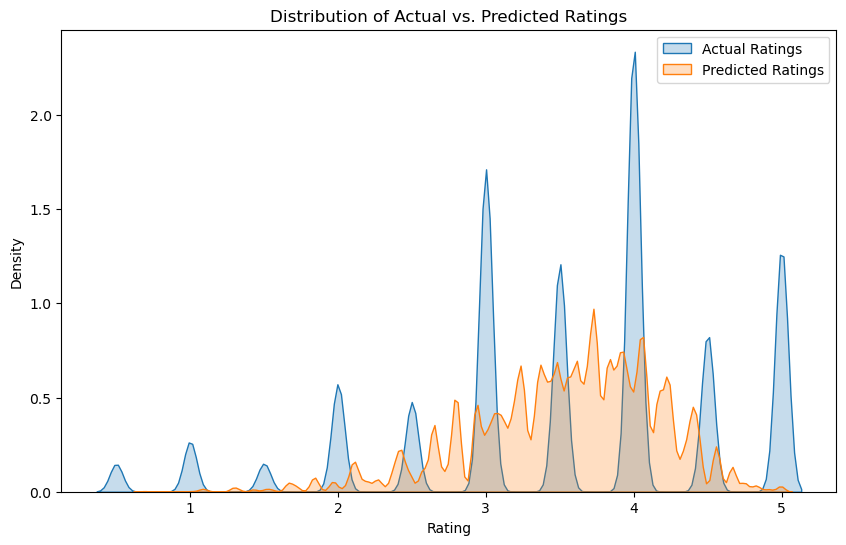

In [41]:
# Create a dataframe for comparison
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(comparison_df['Actual'], label='Actual Ratings', fill=True)
sns.kdeplot(comparison_df['Predicted'], label='Predicted Ratings', fill=True)
plt.title('Distribution of Actual vs. Predicted Ratings')
plt.xlabel('Rating')
plt.legend()
plt.show()


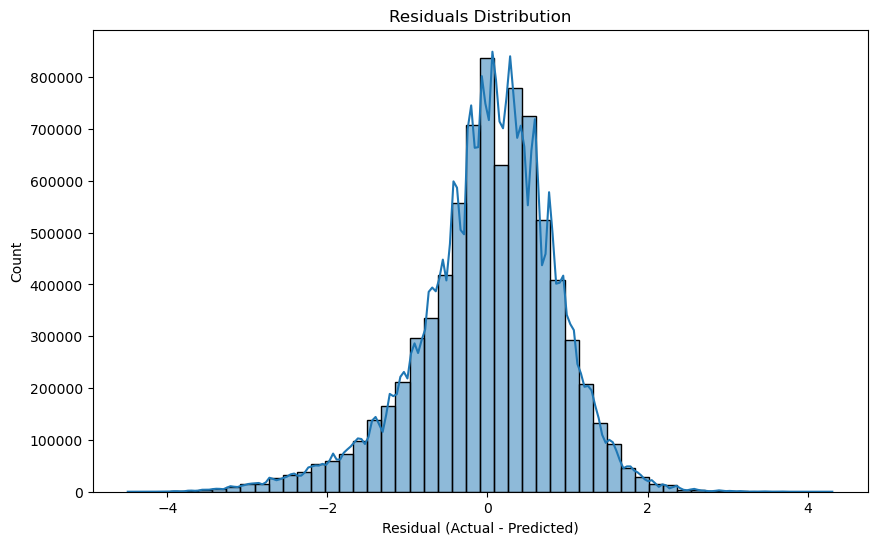

In [38]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residual (Actual - Predicted)')
plt.show()
